In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [30]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [31]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([3, 4, 7, 9, 5, 6, 1, 8, 2]), tensor([10,  0]))

In [32]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

# 活性化関数
* 線形変換と組み合わせることで任意の関数を近似することができる
* 線形演算の出力結果を特定の数値範囲に変換できる
* 微分可能である. ReLUやHardtanhの特定の点での不連続性は問題にならない
* 入力に対して感度の高い領域を少なくとも１つ以上は保有し、入力値の重要な変化に対して出力値も大きく変化する
* 逆に入力値を変更しても出力値にほとんど変化がないか全く変化しないような不感応領域(飽和領域)も保有する

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[-2.2541],
        [-1.4180]], grad_fn=<AddmmBackward0>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[-0.2166]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([-0.9458], requires_grad=True)

In [11]:
x = torch.ones(1)
linear_model(x)

tensor([-1.1624], grad_fn=<AddBackward0>)

# バッチ計算の利点

* バッチでデータを与えることでアイドル状態のユニットに計算を分散させることができる
* モデルの中にはバッチ全体の統計情報を使用しているものが存在しており、バッチサイズが大きくなるほどその作用は大きくなる

In [17]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

In [19]:
linear_model.parameters()

<generator object Module.parameters at 0x794abbeba6c0>

In [21]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.2215]], requires_grad=True),
 Parameter containing:
 tensor([-0.4920], requires_grad=True)]

In [26]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f'Epoch {epoch}, Training loss {loss_train.item():.4f},' f'Validation loss {loss_val.item():.4f}')

In [33]:
# 自作で損失関数を作らなくても良い # <1>
# def loss_fn(t_p, t_c):
#     squared_diffs = (t_p - t_c)**2
#     return squared_diffs.mean()

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    # loss_fn=loss_fn, #<1>
    loss_fn= nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 356.5471,Validation loss 408.5857
Epoch 1000, Training loss 3.7585,Validation loss 7.2037
Epoch 2000, Training loss 3.0058,Validation loss 3.9185
Epoch 3000, Training loss 2.9802,Validation loss 3.4294

Parameter containing:
tensor([[5.1397]], requires_grad=True)
Parameter containing:
tensor([-16.1423], requires_grad=True)


In [34]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [35]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [36]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [37]:
# parametaers に名前をつける
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [39]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [40]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.2483], requires_grad=True)

In [41]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 176.3357,Validation loss 216.7804
Epoch 1000, Training loss 7.4019,Validation loss 5.9532
Epoch 2000, Training loss 4.5637,Validation loss 5.0095
Epoch 3000, Training loss 2.5946,Validation loss 2.4806
Epoch 4000, Training loss 1.9704,Validation loss 1.7475
Epoch 5000, Training loss 1.8897,Validation loss 1.9767
output tensor([[20.5143],
        [ 2.4282]], grad_fn=<AddmmBackward0>)
answer tensor([[21.0000],
        [ 0.5000]])
hidden tensor([[ 0.0180],
        [-0.0205],
        [ 0.0067],
        [-0.0052],
        [-0.0057],
        [-0.0304],
        [-0.0097],
        [-0.0355]])


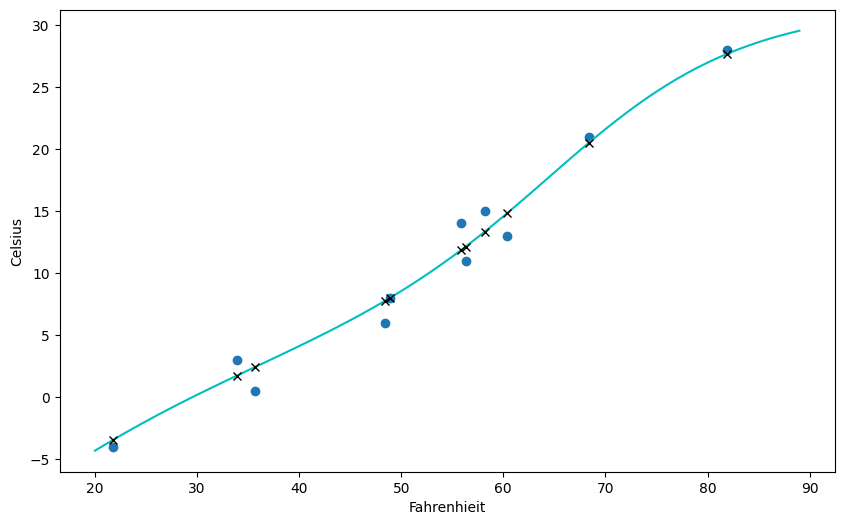

In [53]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(figsize=[10, 6])
plt.xlabel('Fahrenhieit')
plt.ylabel('Celsius')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')